In [81]:
import torch
from torch_geometric.datasets import Planetoid
from hivegraph.contrastive.grace import GRACE
from sklearn.linear_model import LogisticRegression
from util import * 
from torch_geometric.utils import to_dense_adj
import torch_geometric.transforms as T 
from augmentation import *
from query_strategies import *
import matplotlib.pyplot as plt


In [82]:
data_splits = [torch.load(f"data_splits/split_{i}.pt") for i in range(10)]
dataset_o = data_splits[0].to('cuda')

/tmp/ipykernel_1122203/1654566899.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_splits = [torch.load(f"data_splits/split_{i}.pt") for i in range(10)]


In [83]:
device = 'cuda'

In [84]:
model = GRACE(num_features=dataset_o.num_features,hidden=128, num_layers=2, drop_edge_rate_1=0.3,drop_edge_rate_2=0.3,drop_feature_rate_1=0.3,drop_feature_rate_2=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [85]:
dataset_o.contrastive_validation_mask = dataset_o.val_mask
dataset_o.contrastive_train_mask = ~dataset_o.val_mask

In [86]:
for epoch in range(200):
    opt.zero_grad()
    loss = model.train_step(dataset_o.x,dataset_o.edge_index)
    print(loss)
    loss.backward()
    opt.step()

tensor(8.5747, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0733, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5144, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4745, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4215, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3350, device='cuda:0',

In [87]:
out = model(dataset_o.x,dataset_o.edge_index)

In [88]:
DROPOUT= 0.3
NUM_PASSES = 10
BUDGET = 150
EPOCHS = 100
SIGNIFICANCE_ITERATIONS = 10

NOISE_PROB = 0.4
NOISE_LEVEL = 1.0

In [89]:
# Augmentations
drop_edge = DropEdge(DROPOUT)
noise_feature_all = NoiseFeature(NOISE_LEVEL, 1)
noise_feature_col = NoiseFeature(NOISE_LEVEL, NOISE_PROB, "col")
noise_feature_row = NoiseFeature(NOISE_LEVEL, NOISE_PROB, "row")
noise_latent = NoiseLatent(NOISE_LEVEL)
mask_feature = MaskFeature(DROPOUT)

drop_edge_noise_all = T.Compose([drop_edge, noise_feature_all])
drop_edge_noise_col = T.Compose([drop_edge, noise_feature_col])
drop_edge_noise_row = T.Compose([drop_edge, noise_feature_row])
drop_edge_mask_feature = T.Compose([drop_edge, mask_feature])

In [90]:
# AUGMENTED ENTROPY
dataset = dataset_o.clone()
acc_aug = []
for b in range(BUDGET):
    pool_indices = get_mask_indices(dataset.train_pool).cpu()

    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())

    entropy_sum = torch.zeros(dataset.num_nodes)
    
    for _ in range(NUM_PASSES):
        data_tmp = dataset.clone()
        data_tmp = drop_edge_noise_all(data_tmp)
        out_c = model(data_tmp.x, data_tmp.edge_index)
        pred_log_probas = predictor.predict_log_proba(out_c.detach().cpu().numpy())
        entropies = calculate_entropy(torch.tensor(pred_log_probas))
        entropy_sum += entropies
        
    pred_log_probas = predictor.predict_log_proba(out.detach().cpu().numpy())
    entropy_o = calculate_entropy(torch.tensor(pred_log_probas))
    entropy_sum +=entropy_o
    entropy_sum /= NUM_PASSES
    
    
    
    
    
    chosen_node_ix = torch.argmax(entropy_sum[pool_indices])
    chosen_node = pool_indices[chosen_node_ix]
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    
    predictor = LogisticRegression()
    acc_aug.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")

Budget 0 - Accuracy: 0.504
Budget 1 - Accuracy: 0.344
Budget 2 - Accuracy: 0.555
Budget 3 - Accuracy: 0.526
Budget 4 - Accuracy: 0.579
Budget 5 - Accuracy: 0.616
Budget 6 - Accuracy: 0.664
Budget 7 - Accuracy: 0.637
Budget 8 - Accuracy: 0.63
Budget 9 - Accuracy: 0.635
Budget 10 - Accuracy: 0.627
Budget 11 - Accuracy: 0.672
Budget 12 - Accuracy: 0.67
Budget 13 - Accuracy: 0.684
Budget 14 - Accuracy: 0.658
Budget 15 - Accuracy: 0.656
Budget 16 - Accuracy: 0.652
Budget 17 - Accuracy: 0.641
Budget 18 - Accuracy: 0.638
Budget 19 - Accuracy: 0.636
Budget 20 - Accuracy: 0.632
Budget 21 - Accuracy: 0.644
Budget 22 - Accuracy: 0.665
Budget 23 - Accuracy: 0.657
Budget 24 - Accuracy: 0.636
Budget 25 - Accuracy: 0.635
Budget 26 - Accuracy: 0.612
Budget 27 - Accuracy: 0.606
Budget 28 - Accuracy: 0.602
Budget 29 - Accuracy: 0.586
Budget 30 - Accuracy: 0.573
Budget 31 - Accuracy: 0.633
Budget 32 - Accuracy: 0.631
Budget 33 - Accuracy: 0.622
Budget 34 - Accuracy: 0.648
Budget 35 - Accuracy: 0.652
Budg

In [91]:
out.shape

torch.Size([2708, 128])

In [92]:
out_n = out.detach()

In [93]:
def predict_log_proba_sklearn_model(model, x):
    out = x @ model.coef_.T + model.intercept_
    out = torch.tensor(out)
    return torch.nn.functional.log_softmax(out, dim=1)

In [94]:
class PredictorWrapper():
    def __init__(self, model):
        self.weights = torch.tensor(model.coef_.T, dtype=torch.float32).cuda()
        self.weights.requires_grad = False
        self.bias = torch.tensor(model.intercept_, dtype=torch.float32).cuda()
        self.bias.requires_grad = False
    def predict_log_proba(self, x):
        out =  x @ self.weights + self.bias
        return torch.nn.functional.log_softmax(out, dim=1)

In [95]:
# LATENT NOISE

dataset = dataset_o.clone()
acc_laten_noise_o = []
out_a = out.clone()
for b in range(BUDGET):
    pool_indices = get_mask_indices(dataset.train_pool).cpu()

    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())

    entropy_sum = torch.zeros(dataset.num_nodes)
    
    for _ in range(NUM_PASSES):
        out_c = out_a + noise_latent(out_a)
        pred_log_probas = predictor.predict_log_proba(out_c.detach().cpu().numpy())
        entropies = calculate_entropy(torch.tensor(pred_log_probas))
        entropy_sum += entropies
    entropy_sum /= NUM_PASSES
    
    chosen_node_ix = torch.argmax(entropy_sum[pool_indices])
    chosen_node = pool_indices[chosen_node_ix]
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    
    acc_laten_noise_o.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")

Budget 0 - Accuracy: 0.504
Budget 1 - Accuracy: 0.275
Budget 2 - Accuracy: 0.382
Budget 3 - Accuracy: 0.45
Budget 4 - Accuracy: 0.604
Budget 5 - Accuracy: 0.601
Budget 6 - Accuracy: 0.676
Budget 7 - Accuracy: 0.599
Budget 8 - Accuracy: 0.649
Budget 9 - Accuracy: 0.692
Budget 10 - Accuracy: 0.734
Budget 11 - Accuracy: 0.717
Budget 12 - Accuracy: 0.648
Budget 13 - Accuracy: 0.628
Budget 14 - Accuracy: 0.597
Budget 15 - Accuracy: 0.639
Budget 16 - Accuracy: 0.715
Budget 17 - Accuracy: 0.691
Budget 18 - Accuracy: 0.673
Budget 19 - Accuracy: 0.697
Budget 20 - Accuracy: 0.731
Budget 21 - Accuracy: 0.699
Budget 22 - Accuracy: 0.715
Budget 23 - Accuracy: 0.714
Budget 24 - Accuracy: 0.726
Budget 25 - Accuracy: 0.735
Budget 26 - Accuracy: 0.73
Budget 27 - Accuracy: 0.731
Budget 28 - Accuracy: 0.723
Budget 29 - Accuracy: 0.709
Budget 30 - Accuracy: 0.706
Budget 31 - Accuracy: 0.716
Budget 32 - Accuracy: 0.723
Budget 33 - Accuracy: 0.736
Budget 34 - Accuracy: 0.725
Budget 35 - Accuracy: 0.724
Budg

In [96]:
# ENTROPY
dataset = dataset_o.clone()
acc_entropy = []
for b in range(BUDGET):
    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())
    pred_log_probas = predictor.predict_log_proba(out.detach().cpu().numpy())
    entropies = calculate_entropy(torch.tensor(pred_log_probas))
    pool_indices = get_mask_indices(dataset.train_pool).cpu()
    chosen_node_ix = torch.argmax(entropies[pool_indices])
    chosen_node = pool_indices[chosen_node_ix]
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    predictor = LogisticRegression()
    acc_entropy.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")
    

Budget 0 - Accuracy: 0.504
Budget 1 - Accuracy: 0.408
Budget 2 - Accuracy: 0.527
Budget 3 - Accuracy: 0.53
Budget 4 - Accuracy: 0.547
Budget 5 - Accuracy: 0.592
Budget 6 - Accuracy: 0.634
Budget 7 - Accuracy: 0.566
Budget 8 - Accuracy: 0.574
Budget 9 - Accuracy: 0.593
Budget 10 - Accuracy: 0.623
Budget 11 - Accuracy: 0.635
Budget 12 - Accuracy: 0.6
Budget 13 - Accuracy: 0.581
Budget 14 - Accuracy: 0.605
Budget 15 - Accuracy: 0.655
Budget 16 - Accuracy: 0.667
Budget 17 - Accuracy: 0.694
Budget 18 - Accuracy: 0.71
Budget 19 - Accuracy: 0.714
Budget 20 - Accuracy: 0.707
Budget 21 - Accuracy: 0.708
Budget 22 - Accuracy: 0.719
Budget 23 - Accuracy: 0.719
Budget 24 - Accuracy: 0.734
Budget 25 - Accuracy: 0.743
Budget 26 - Accuracy: 0.74
Budget 27 - Accuracy: 0.742
Budget 28 - Accuracy: 0.725
Budget 29 - Accuracy: 0.727
Budget 30 - Accuracy: 0.736
Budget 31 - Accuracy: 0.727
Budget 32 - Accuracy: 0.721
Budget 33 - Accuracy: 0.719
Budget 34 - Accuracy: 0.73
Budget 35 - Accuracy: 0.729
Budget 3

In [97]:
# LATENT DISTANCE
BUDGET = 150
dataset = dataset_o.clone()
acc_latent = []
for b in range(BUDGET):
    
    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())
    
    pool_indices = get_mask_indices(dataset.train_pool).cpu()

    dist_matrix = torch.cdist(out[dataset.train_pool], out[dataset.train_pool])
    adj = to_dense_adj(dataset.edge_index)[0][dataset.train_pool][:,dataset.train_pool]
    adj = adj.cuda()
    dist_matrix = dist_matrix * adj
    
    
    max_dist = dist_matrix.mean(dim=1)
    min_max_dist = torch.argmin(max_dist)
    chosen_node = pool_indices[min_max_dist]

    
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    # predictor = LogisticRegression()
    acc_latent.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")

Budget 0 - Accuracy: 0.504
Budget 1 - Accuracy: 0.284
Budget 2 - Accuracy: 0.355
Budget 3 - Accuracy: 0.538
Budget 4 - Accuracy: 0.557
Budget 5 - Accuracy: 0.474
Budget 6 - Accuracy: 0.506
Budget 7 - Accuracy: 0.502
Budget 8 - Accuracy: 0.514
Budget 9 - Accuracy: 0.559
Budget 10 - Accuracy: 0.563
Budget 11 - Accuracy: 0.542
Budget 12 - Accuracy: 0.569
Budget 13 - Accuracy: 0.554
Budget 14 - Accuracy: 0.535
Budget 15 - Accuracy: 0.573
Budget 16 - Accuracy: 0.57
Budget 17 - Accuracy: 0.588
Budget 18 - Accuracy: 0.589
Budget 19 - Accuracy: 0.627
Budget 20 - Accuracy: 0.626
Budget 21 - Accuracy: 0.6
Budget 22 - Accuracy: 0.588
Budget 23 - Accuracy: 0.583
Budget 24 - Accuracy: 0.591
Budget 25 - Accuracy: 0.588
Budget 26 - Accuracy: 0.581
Budget 27 - Accuracy: 0.555
Budget 28 - Accuracy: 0.569
Budget 29 - Accuracy: 0.556
Budget 30 - Accuracy: 0.582
Budget 31 - Accuracy: 0.565
Budget 32 - Accuracy: 0.563
Budget 33 - Accuracy: 0.574
Budget 34 - Accuracy: 0.566
Budget 35 - Accuracy: 0.595
Budge

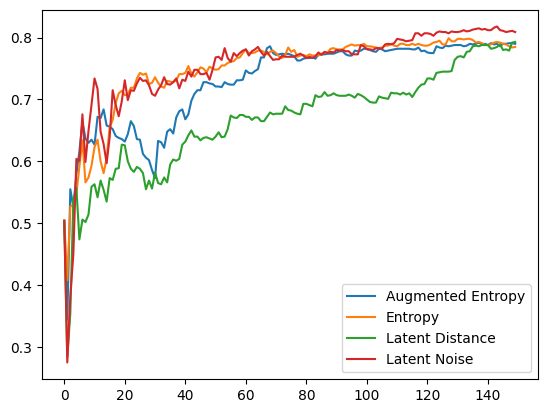

In [98]:

plt.plot(acc_aug, label="Augmented Entropy")
plt.plot(acc_entropy, label="Entropy")
plt.plot(acc_latent, label="Latent Distance")
# plt.plot(acc_laten_noise, label="Latent Noise ADV")
plt.plot(acc_laten_noise_o, label="Latent Noise")
plt.legend()
plt.show()